# Push Notifications DS Project

## Project Overview
The project aims to build a **targeted push notification system** for a grocery store app. The goal is to use a predictive machine learning model to identify users who are highly likely to purchase specific promotional items, then send them personalized push notifications. This approach seeks to boost sales while minimizing user churn from intrusive notifications (current open rate is ~5%).

## Key Requirements
- Target only users likely to make purchases of **at least 5 items** (due to shipping cost considerations)
- Enable sales operators to select items via dropdown/search and trigger customizable notifications
- Achieve a **2% increase in monthly sales** and **25% boost for selected items**
- Deliver a **Proof of Concept (PoC) within 1 week**

## Milestone 1 Scope
The first milestone focuses on the **exploration phase** of the data science component:

1. **Data Preparation**: Filter the existing groceries dataset (`feature_frame.csv`) to include only orders with 5+ items
2. **Model Development**: Build and evaluate linear models using train/validation/test splits (chosen for speed due to tight timeline)
3. **Model Selection**: Compare different approaches and select the best-performing model
4. **Documentation**: Deliver a comprehensive report/notebook documenting what worked, what didn't, and the reasoning behind decisions

The milestone should result in a **final model selection** ready for implementation in milestone 2, with the EDA phase skipped since the team has prior experience with this dataset.


In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    auc,
    average_precision_score,
    precision_recall_curve,
    roc_curve,
)
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import StandardScaler
from sklearn.pipeline import make_pipeline

In [3]:
data_source = "/home/pedrotejero/zrive-ds/data/groceries/box_builder_dataset/feature_frame.csv"
df = pd.read_csv(data_source)

In [4]:
df.head(10)

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
5,33826472919172,ricepastapulses,2808434524292,3479090790532,2020-10-06 10:50:23,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
6,33826472919172,ricepastapulses,2808548917380,3476645445764,2020-10-06 14:23:08,2020-10-06 00:00:00,5,0.0,1.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
7,33826472919172,ricepastapulses,2808549900420,3437017956484,2020-10-06 14:24:26,2020-10-06 00:00:00,13,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
8,33826472919172,ricepastapulses,2808673927300,3539005440132,2020-10-06 17:57:23,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
9,33826472919172,ricepastapulses,2808728715396,3421126885508,2020-10-06 19:36:06,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [5]:
df.shape

(2880549, 27)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880549 entries, 0 to 2880548
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      fl

## Filtering Data

Let's filter the dataset to keep only the orders with 5 or more products successfully sold.

In [7]:
orders_with_outcome_1 = df[df['outcome'] == 1]

target_orders = orders_with_outcome_1.groupby('order_id')['variant_id'].nunique()
target_orders = target_orders[target_orders >= 5]
target_orders_list = target_orders.index.values
target_orders

order_id
2807985930372     9
2808027644036     6
2808099078276     9
2808393957508    13
2808434524292     7
                 ..
3643241300100    10
3643254800516     9
3643274788996     5
3643283734660    21
3643294515332     7
Name: variant_id, Length: 2603, dtype: int64

In [8]:
data = df[df['order_id'].isin(target_orders_list)]

print("Original DataFrame shape: ", df.shape)
print("Data filtered shape: ", data.shape)

difference = df.shape[0] - data.shape[0]
print(f"Difference: {difference} rows removed, {round(difference/df.shape[0]*100, 2)}% of the data")

Original DataFrame shape:  (2880549, 27)
Data filtered shape:  (2163953, 27)
Difference: 716596 rows removed, 24.88% of the data


## Splitting Data

Let's analyze the daily sales that have occurred over time.

In [9]:
def process_data(data, percentage_to_remove=0.10):
    """
    Process the data by removing a percentage of first orders.
    
    Args:
        data (pd.DataFrame): Input dataframe
        percentage_to_remove (float): Percentage of first orders to remove (default: 0.10)
    
    Returns:
        tuple: (original_data, filtered_data, orders_to_remove)
    """
    data['order_date'] = pd.to_datetime(data['order_date'])
    data = data.sort_values(by='order_date', ascending=True)
    order_list = data['order_id'].unique()
    
    n_orders_to_remove = int(len(order_list) * percentage_to_remove)
    orders_to_remove = order_list[:n_orders_to_remove]
    
    original_data = data.copy()
    filtered_data = data[~data['order_id'].isin(orders_to_remove)].copy()
    
    return original_data, filtered_data, orders_to_remove

def calculate_daily_orders(data):
    """
    Calculate daily orders from the dataset.
    
    Args:
        data (pd.DataFrame): Input dataframe
    
    Returns:
        pd.Series: Daily orders count
    """
    return data.groupby('order_date')['order_id'].nunique()

def plot_daily_orders_comparison(daily_orders_original, daily_orders_filtered, percentage_to_remove):
    """
    Create a comparison plot of daily orders.
    
    Args:
        daily_orders_original (pd.Series): Original daily orders
        daily_orders_filtered (pd.Series): Filtered daily orders
        percentage_to_remove (float): Percentage of orders removed
    """
    plt.figure(figsize=(15, 6))
    plt.plot(daily_orders_original.index, daily_orders_original.values, 
             label='Original Orders', alpha=0.7)
    plt.plot(daily_orders_filtered.index, daily_orders_filtered.values, 
             label=f'Orders after removing {percentage_to_remove*100}% of first orders', alpha=0.7)
    plt.title('Comparison of Daily Orders: Original vs Filtered')
    plt.xlabel('Date')
    plt.ylabel('Number of Orders')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

def print_statistics(data, daily_orders, label):
    """
    Print statistics for a dataset.
    
    Args:
        data (pd.DataFrame): Input dataframe
        daily_orders (pd.Series): Daily orders series
        label (str): Label for the statistics section
    """
    print(f"\n{label}:")
    print(f"Average daily orders: {daily_orders.mean():.2f}")
    print(f"Maximum daily orders: {daily_orders.max()}")
    print(f"Minimum daily orders: {daily_orders.min()}")
    print(f"Total number of days: {len(daily_orders)}")
    print(f"Total number of orders: {len(data['order_id'].unique())}")
    print(f"Total number of entries: {len(data)}")

def filter_orders(data, percentage_to_remove=0.10):
    """
    Main function to filter orders data.
    
    Args:
        data (pd.DataFrame): Input dataframe
        percentage_to_remove (float): Percentage of first orders to remove (default: 0.10)
    """
    original_data, filtered_data, _ = process_data(data, percentage_to_remove)
    
    daily_orders_original = calculate_daily_orders(original_data)
    daily_orders_filtered = calculate_daily_orders(filtered_data)
    
    plot_daily_orders_comparison(daily_orders_original, daily_orders_filtered, percentage_to_remove)
    
    print_statistics(original_data, daily_orders_original, "Original Data")
    print_statistics(filtered_data, daily_orders_filtered, 
                     f"Filtered Data (after removing first {percentage_to_remove*100}% of orders)")
    
    return filtered_data

/tmp/ipykernel_9195/2855717595.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['order_date'] = pd.to_datetime(data['order_date'])


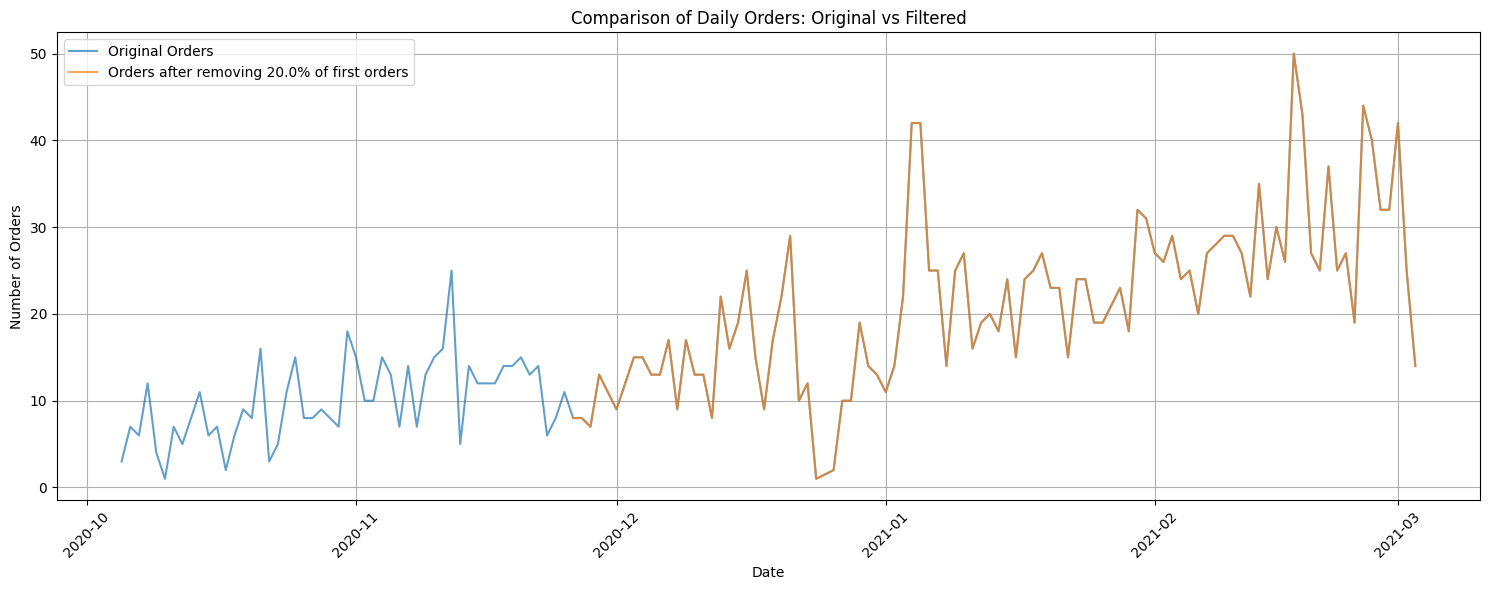


Original Data:
Average daily orders: 17.47
Maximum daily orders: 50
Minimum daily orders: 1
Total number of days: 149
Total number of orders: 2603
Total number of entries: 2163953

Filtered Data (after removing first 20.0% of orders):
Average daily orders: 21.47
Maximum daily orders: 50
Minimum daily orders: 1
Total number of days: 97
Total number of orders: 2083
Total number of entries: 1798640


In [104]:
df_filtered = filter_orders(data, percentage_to_remove=0.20)

As we can see, the business has been growing and in recent months daily sales are 3 or 4 times higher than at the beginning. Given that we have plenty of data to train a linear model, I'm making a design decision to remove a percentage of the initial data since I don't believe they represent the current reality of the business we're trying to predict, which could introduce noise into the model and worsen our results and predictive power.

In [105]:
df_filtered = df_filtered.sort_values(by='order_date', ascending=True)
orders_list = df_filtered['order_id'].unique()
n_total = len(orders_list)
split_value = 0.75
cutoff = int(split_value * n_total)

train_split = orders_list[0:cutoff]
test_split = orders_list[cutoff:]

print(f"Total orders: {n_total}")
print(f"Train orders: {len(train_split)}")
print(f"Test orders: {len(test_split)}")

Total orders: 2083
Train orders: 1562
Test orders: 521


In [107]:
train_df = df_filtered[df_filtered['order_id'].isin(train_split)]
test_df = df_filtered[df_filtered['order_id'].isin(test_split)]

print(train_df.shape)
print(test_df.shape)

print(f"\nTrain since: {train_df['order_date'].min()}")
print(f"Train until: {train_df['order_date'].max()}")
print(f"Test since: {test_df['order_date'].min()}")
print(f"Test until: {test_df['order_date'].max()}")

(1311238, 27)
(487402, 27)

Train since: 2020-11-26 00:00:00
Train until: 2021-02-15 00:00:00
Test since: 2021-02-15 00:00:00
Test until: 2021-03-03 00:00:00


I don't use a validation dataset because when splitting the data temporally, the training data would be too far from the current data. Additionally, this way I ensure that test dataframe represents some weeks, gaining stability and robustness against specific temporal effects that could affect the model evaluation.

## Baseline
As a baseline, I have chosen the value of total sales for each product.

In [13]:
product_sales = train_df.groupby('variant_id').apply(
    lambda x: x.loc[x['outcome'] == 1, 'order_id'].count()
)
product_sales

/tmp/ipykernel_9195/2163194915.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_sales = train_df.groupby('variant_id').apply(


variant_id
33615294398596    17
33667172466820     0
33667174301828     7
33667174334596     6
33667174465668    35
                  ..
34535159595140     1
34535159660676     4
34535159693444     1
34535162118276     1
34535162151044     6
Length: 898, dtype: int64

In [14]:
product_sales_norm = product_sales / product_sales.sum()
print(product_sales.sum())
print(product_sales_norm.sum())
product_sales_norm

18572
1.0


variant_id
33615294398596    0.000915
33667172466820    0.000000
33667174301828    0.000377
33667174334596    0.000323
33667174465668    0.001885
                    ...   
34535159595140    0.000054
34535159660676    0.000215
34535159693444    0.000054
34535162118276    0.000054
34535162151044    0.000323
Length: 898, dtype: float64

In [15]:
baseline = test_df.copy().reset_index(drop=True)
baseline['probability'] = baseline['variant_id'].map(product_sales_norm).fillna(0)
baseline


,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type,probability
0,33826472919172,ricepastapulses,2922505601156,3903061262468,2021-02-15 07:51:04,2021-02-15 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180,0.001292
1,33826472919172,ricepastapulses,2922529063044,3828300021892,2021-02-15 08:47:44,2021-02-15 00:00:00,5,0.0,0.0,0.0,...,0.0,0.0,2.0,33.0,42.0,31.134053,11.0,30.0,24.276180,0.001292
2,33826472919172,ricepastapulses,2922572218500,3896491475076,2021-02-15 10:51:59,2021-02-15 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180,0.001292
3,33826472919172,ricepastapulses,2922586439812,3786618634372,2021-02-15 11:28:01,2021-02-15 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180,0.001292
4,33826472919172,ricepastapulses,2922609672324,3914472784004,2021-02-15 12:25:20,2021-02-15 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,2.0,33.0,42.0,31.134053,11.0,30.0,24.276180,0.001292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487397,33826439594116,healthcarevitamins,3643241300100,3864791220356,2021-03-03 12:56:04,2021-03-03 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392,0.000000
487398,33826439594116,healthcarevitamins,3643254800516,3893722808452,2021-03-03 13:19:28,2021-03-03 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392,0.000000
487399,33826439594116,healthcarevitamins,3643274788996,3883757174916,2021-03-03 13:57:35,2021-03-03 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392,0.000000
487400,33826439594116,healthcarevitamins,3643283734660,3874925314180,2021-03-03 14:14:24,2021-03-03 00:00:00,7,0.0,0.0,0.0,...,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392,0.000000


To evaluate the models, I have chosen ROC and Precision-Recall curves.

1. **ROC (Receiver Operating Characteristic) Curve**:
   - Shows the trade-off between True Positive Rate (Sensitivity) and False Positive Rate (1-Specificity)
   - Useful when:
     - You want to evaluate model performance across different classification thresholds
     - You need to compare models regardless of class distribution
     - You want to assess the model's ability to discriminate between classes
   - The Area Under the Curve (AUC-ROC) provides a single score for model comparison

2. **Precision-Recall Curve**:
   - Shows the trade-off between Precision and Recall
   - Particularly valuable when:
     - Have imbalanced classes
     - The cost of false positives and false negatives is different
     - You're more interested in the positive class (successful sales)
   - The Area Under the Curve (AUC-PR) is especially useful for imbalanced datasets


In [17]:
def plot_evaluation_metrics(
    y_true,
    y_pred_probs_dict,
    figsize=(15, 6),
    title=None
):
    """
    Plot ROC and Precision-Recall curves for multiple models
    
    Parameters:
    -----------
    y_true : array-like
        True binary labels
    y_pred_probs_dict : dict
        Dictionary containing model names as keys and predicted probabilities as values
    figsize : tuple, optional
        Figure size (width, height)
    title : str, optional
        Title for the overall figure
    """

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    if title:
        fig.suptitle(title)
    
    # ROC Curve
    for model_name, y_pred_probs in y_pred_probs_dict.items():
        fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
        roc_auc = auc(fpr, tpr)
        ax1.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})')
    
    ax1.plot([0, 1], [0, 1], 'k--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curves')
    ax1.legend()
    ax1.grid(True)
    
    # Precision-Recall Curve
    for model_name, y_pred_probs in y_pred_probs_dict.items():
        precision, recall, _ = precision_recall_curve(y_true, y_pred_probs)
        pr_auc = auc(recall, precision)
        ax2.plot(recall, precision, label=f'{model_name} (AUC = {pr_auc:.3f})')
    
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall Curves')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    return fig, (ax1, ax2)
    

In [18]:
models = {}

models["baseline"] = baseline['probability']

(<Figure size 1500x600 with 2 Axes>,
 (<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
  <Axes: title={'center': 'Precision-Recall Curves'}, xlabel='Recall', ylabel='Precision'>))

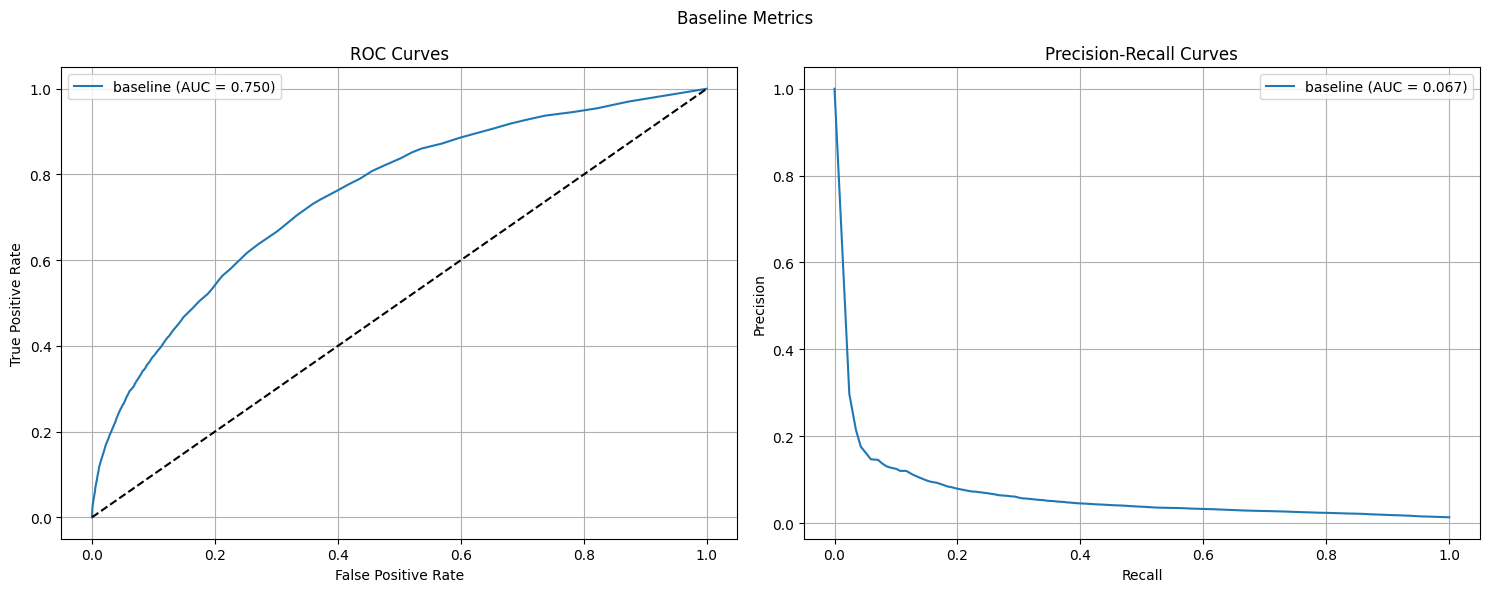

In [19]:
plot_evaluation_metrics(
    y_true=test_df['outcome'],
    y_pred_probs_dict=models,
    title="Baseline Metrics")

## Model Training

In [20]:
X_train, y_train = train_df.drop(columns=['outcome']), train_df['outcome']
X_test, y_test = test_df.drop(columns=['outcome']), test_df['outcome']

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1311238, 26)
(1311238,)
(487402, 26)
(487402,)


In [83]:
binary_cols = [
    "ordered_before",
    "abandoned_before",
    "active_snoozed",
    "set_as_regular",
]

numerical_cols = [
    'user_order_seq',
    'normalised_price',
    'discount_pct',
    'global_popularity',
    'count_adults',
    'count_children',
    'count_babies',
    'count_pets',
    'people_ex_baby',
    'days_since_purchase_variant_id',
    'avg_days_to_buy_variant_id',
    'std_days_to_buy_variant_id',
    'days_since_purchase_product_type',
    'avg_days_to_buy_product_type',
    'std_days_to_buy_product_type',
]

categorical_cols = ["product_type", "vendor"]

In [63]:
training_cols = binary_cols + numerical_cols

Since we are in a binary classification problem, I have selected **Logistic Regression** as the model.

I'm going to use `solver=saga` because I want to try the three types of regularization available. Scikit-learn documentation resume the following:

*The ‘newton-cg’, ‘sag’, and ‘lbfgs’ solvers support only L2 regularization with primal formulation, or no regularization. The ‘liblinear’ solver supports both L1 and L2 regularization, with a dual formulation only for the L2 penalty. The Elastic-Net regularization is only supported by the ‘saga’ solver.*

## Lasso

In [23]:
lasso_train_results = {}
lasso_test_results = {}
lasso_test_results["baseline"] = baseline['probability']


cs = [1e-8, 1e-6, 1e-4, 1e-2, 1, 100, 1e4]
for c in cs:
    rl = make_pipeline(
        StandardScaler(),
        LogisticRegression(
            penalty='l1',
            C=c,
            solver='saga',
            )
    )
    rl.fit(X=X_train[training_cols], y=y_train)

    train_probs = rl.predict_proba(X_train[training_cols])[:, 1]
    lasso_train_results[f"c={c}"] = train_probs

    test_probs = rl.predict_proba(X_test[training_cols])[:, 1]
    lasso_test_results[f"c={c}"] = test_probs


(<Figure size 1500x600 with 2 Axes>,
 (<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
  <Axes: title={'center': 'Precision-Recall Curves'}, xlabel='Recall', ylabel='Precision'>))

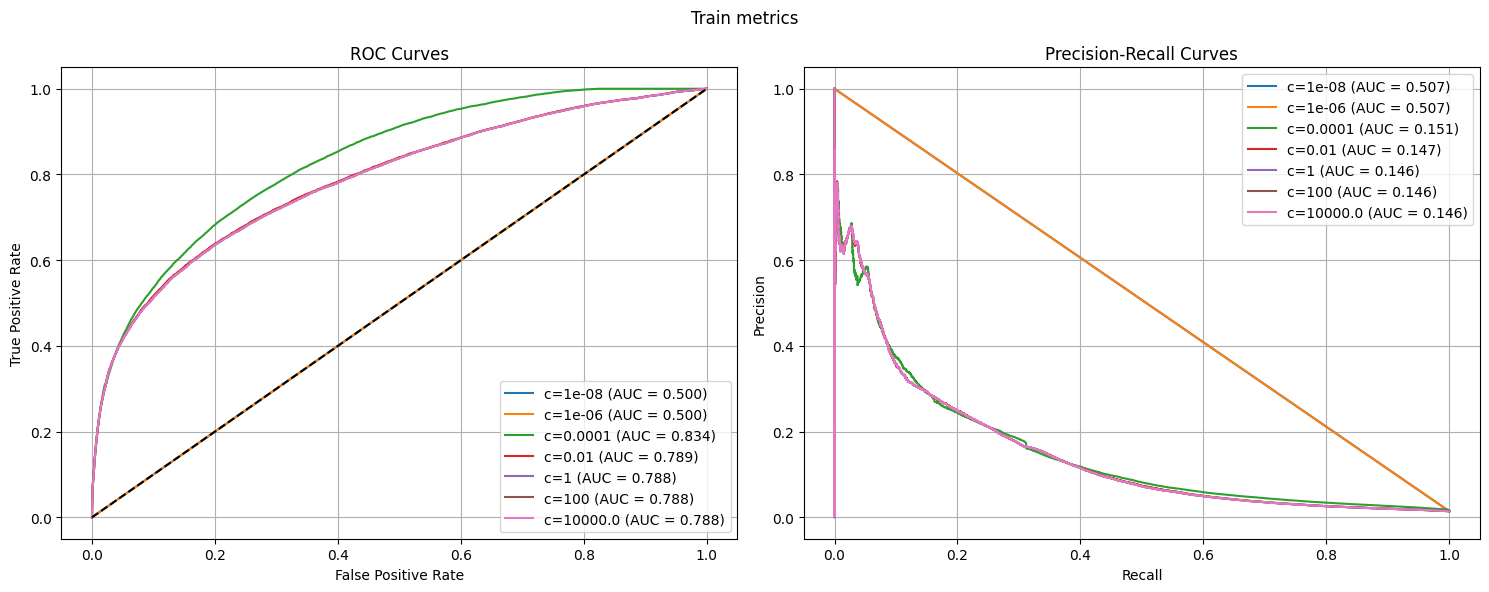

In [24]:
plot_evaluation_metrics(
    y_train,
    lasso_train_results,
    title="Train metrics",
    )

(<Figure size 1500x600 with 2 Axes>,
 (<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
  <Axes: title={'center': 'Precision-Recall Curves'}, xlabel='Recall', ylabel='Precision'>))

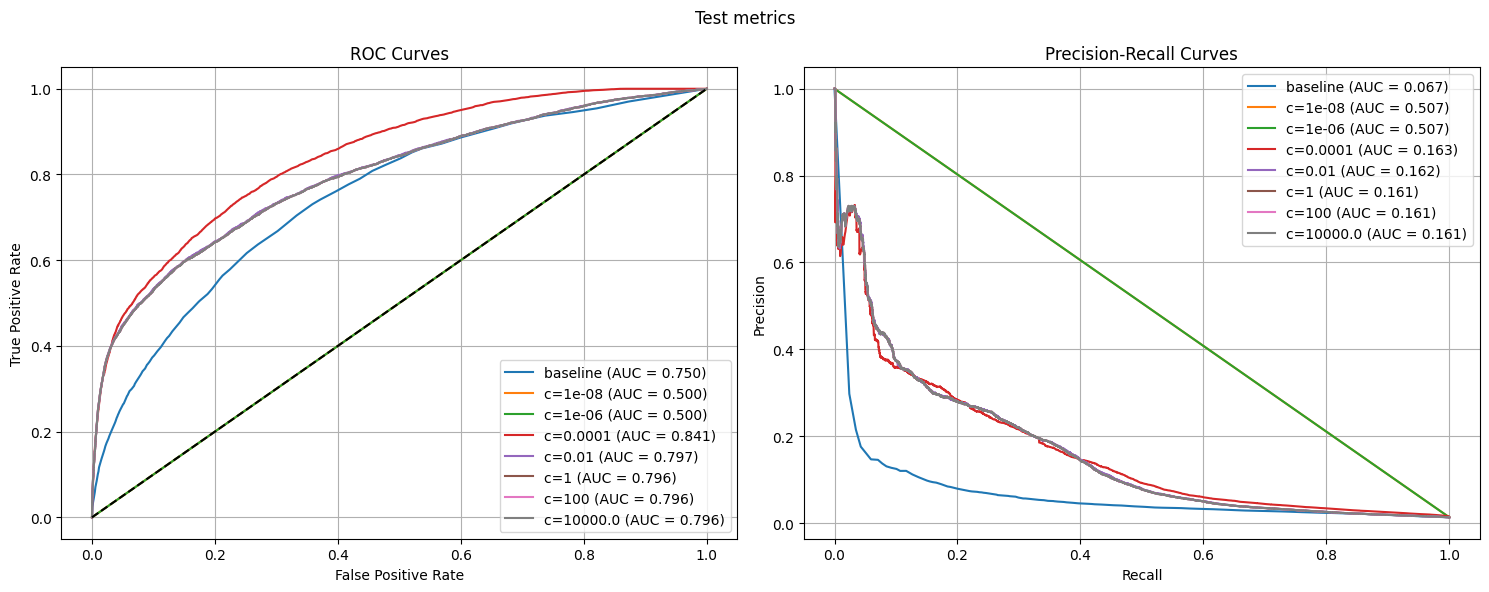

In [25]:
plot_evaluation_metrics(
    y_test,
    lasso_test_results, 
    title="Test metrics",
    )

- Clearly the model improves upon the Baseline.
- There are no signs of overfitting since the results in train and test are very similar.
- I managed to improve a bit the result of the model that Guille presented in his solution (`AUC=0.83`)

## Ridge

In [26]:
ridge_train_results = {}
ridge_test_results = {}
ridge_test_results["baseline"] = baseline['probability']


cs = [1e-8, 1e-6, 1e-4, 1e-2, 1, 100, 1e4]
for c in cs:
    rl = make_pipeline(
        StandardScaler(),
        LogisticRegression(
            penalty='l2',
            C=c,
            solver='saga',
            )
    )
    rl.fit(X=X_train[training_cols], y=y_train)

    train_probs = rl.predict_proba(X_train[training_cols])[:, 1]
    ridge_train_results[f"c={c}"] = train_probs

    test_probs = rl.predict_proba(X_test[training_cols])[:, 1]
    ridge_test_results[f"c={c}"] = test_probs

(<Figure size 1500x600 with 2 Axes>,
 (<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
  <Axes: title={'center': 'Precision-Recall Curves'}, xlabel='Recall', ylabel='Precision'>))

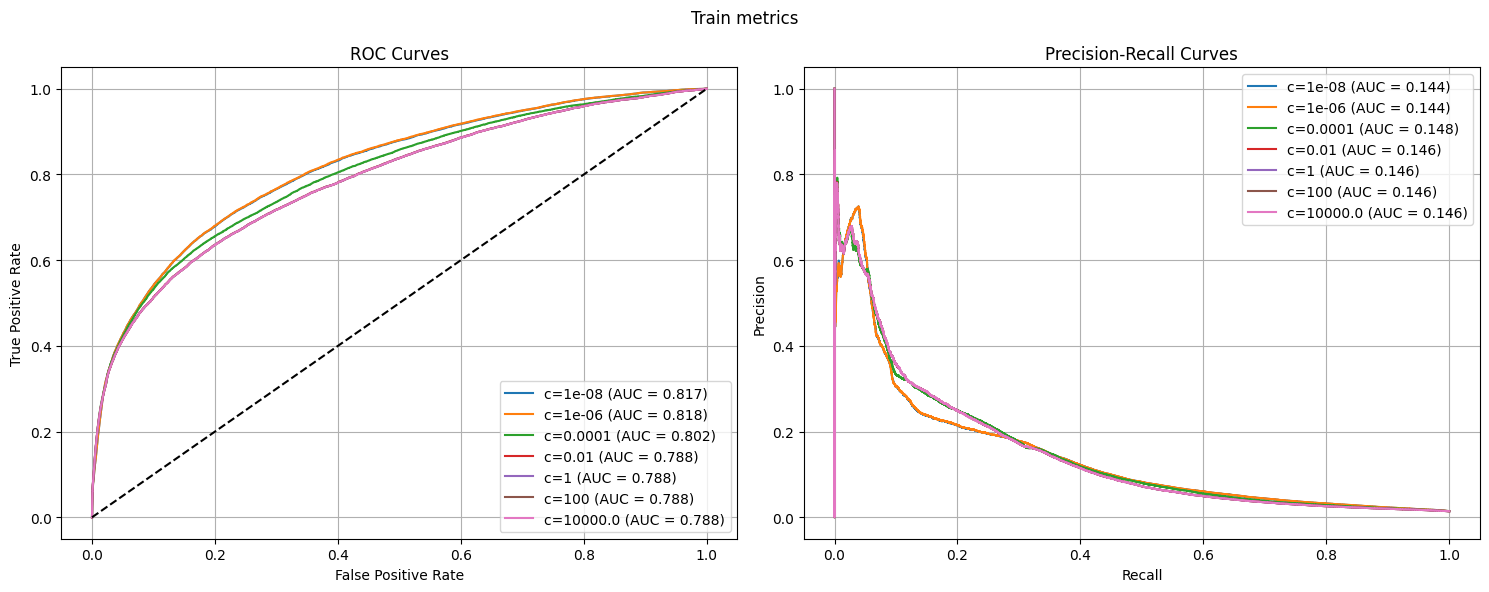

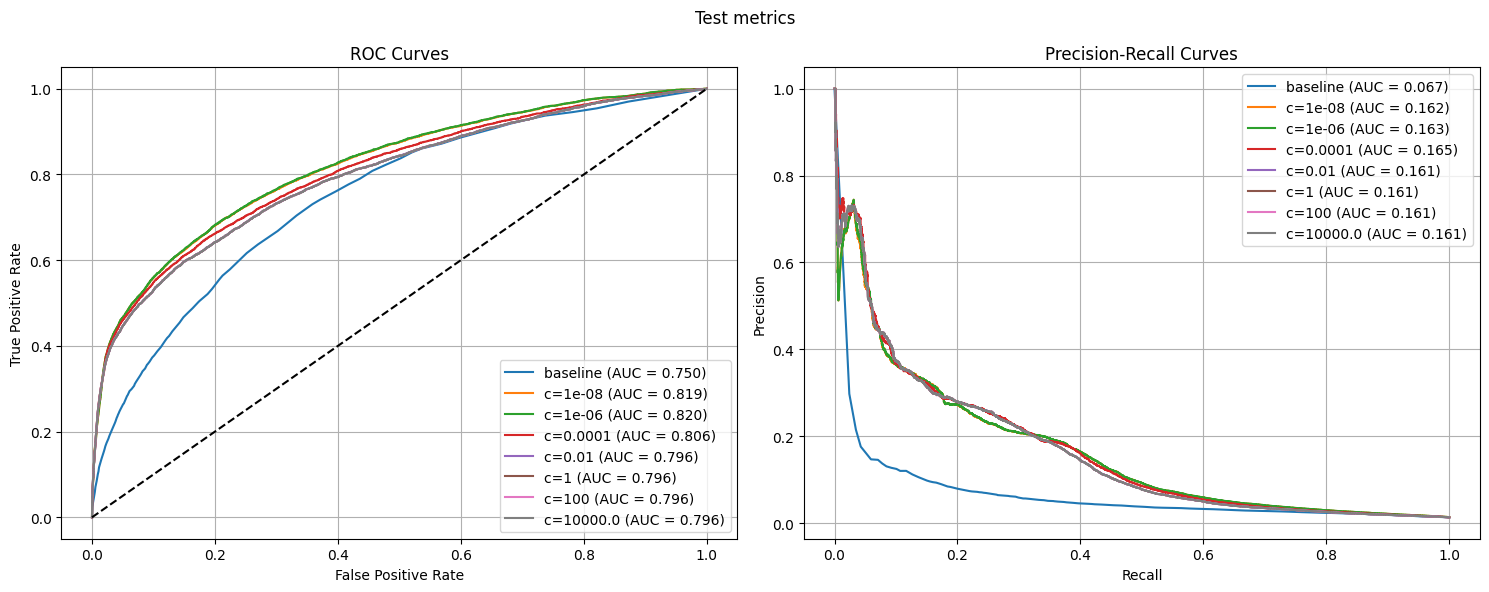

In [27]:
plot_evaluation_metrics(
    y_train,
    ridge_train_results,
    title="Train metrics",
    )

plot_evaluation_metrics(
    y_test,
    ridge_test_results, 
    title="Test metrics",
    )

It improves upon the Baseline but doesn't improve upon Lasso.

## Elastic-Net
**Elastic-Net** is a regularization technique that combines **L1 (Lasso)** and **L2 (Ridge)** penalties. When used in **Logistic Regression**, it helps prevent overfitting by:

* Encouraging **sparse models** (like Lasso) — some coefficients can become zero.
* Stabilizing the model with **shrinkage** (like Ridge) — reducing the magnitude of coefficients.

The balance between L1 and L2 is controlled by the `l1_ratio` parameter.

Setting `l1_ratio=0` is equivalent to using `penalty='l2'`, while setting `l1_ratio=1` is equivalent to using `penalty='l1'`. For `0 < l1_ratio <1`, the penalty is a combination of L1 and L2.


In [39]:
elnet_train_results = {}
elnet_test_results = {}
elnet_test_results["baseline"] = baseline['probability']


l1_rates = np.arange(0.1, 1.0, 0.1).round(1).tolist()
c = 1e-4 # El mejor hasta ahora
for l1_ratio in l1_rates:
    rl = make_pipeline(
        StandardScaler(),
        LogisticRegression(
            penalty='elasticnet',
            l1_ratio=l1_ratio,
            C=c,
            solver='saga',
            )
    )
    rl.fit(X=X_train[training_cols], y=y_train)

    train_probs = rl.predict_proba(X_train[training_cols])[:, 1]
    elnet_train_results[f"l1={l1_ratio}"] = train_probs

    test_probs = rl.predict_proba(X_test[training_cols])[:, 1]
    elnet_test_results[f"l1={l1_ratio}"] = test_probs

(<Figure size 1500x600 with 2 Axes>,
 (<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
  <Axes: title={'center': 'Precision-Recall Curves'}, xlabel='Recall', ylabel='Precision'>))

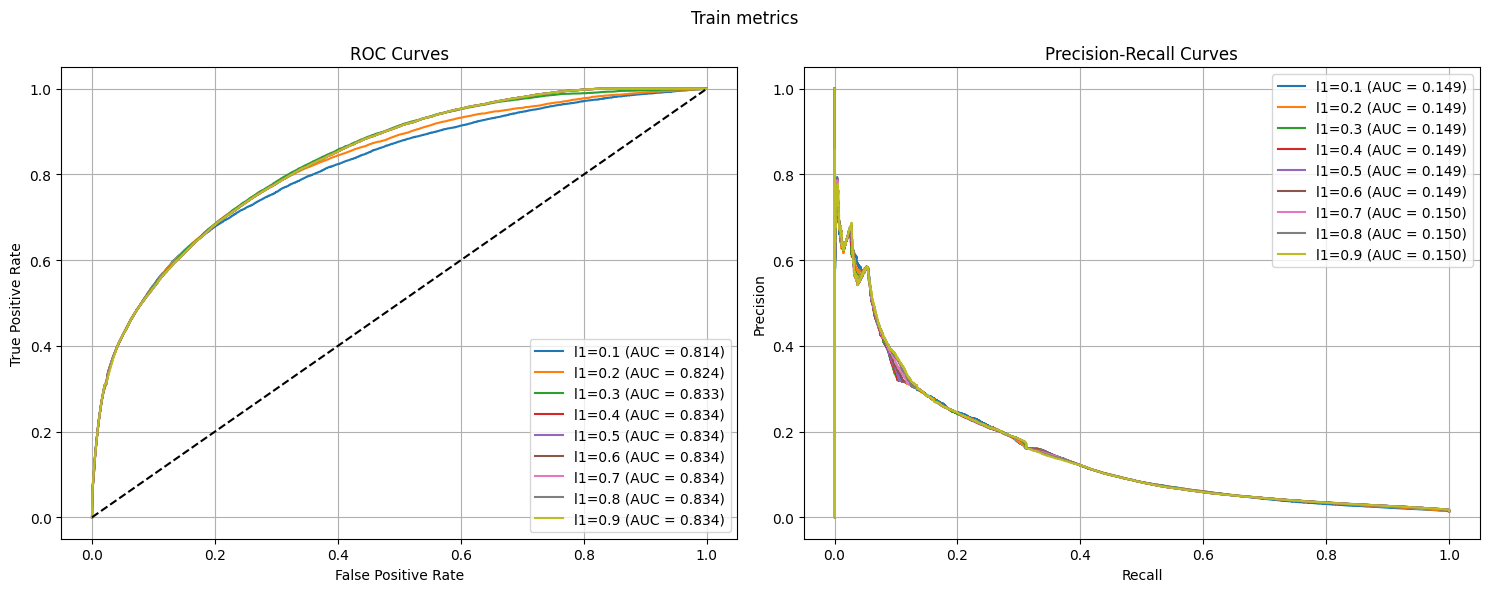

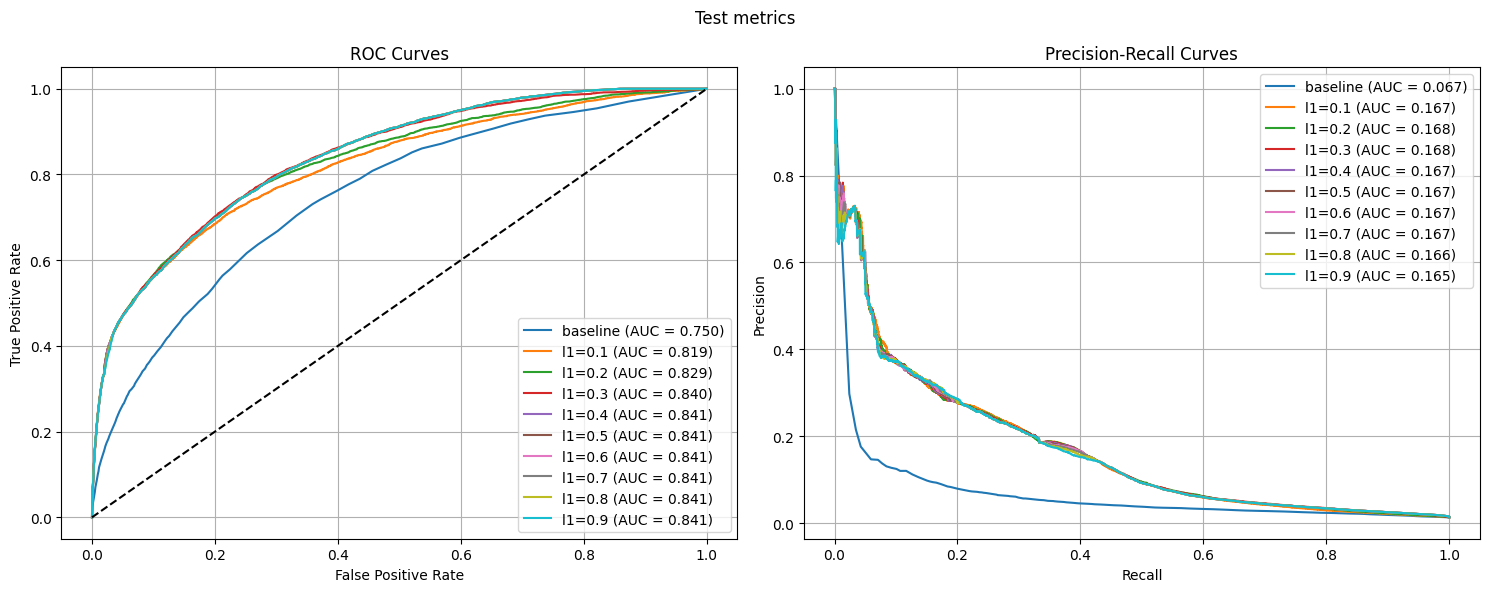

In [40]:
plot_evaluation_metrics(
    y_train,
    elnet_train_results,
    title="Train metrics",
    )

plot_evaluation_metrics(
    y_test,
    elnet_test_results, 
    title="Test metrics",
    )

We see that the AUC values are in the range between those obtained by Ridge and Lasso.

## Coefficients weights
I want to observe the weights that the models attribute to each feature.

In [64]:
lr = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty='l1', C=1e-4, solver="saga")
)
lr.fit(X_train[training_cols], y_train)
lasso_coeffs = pd.DataFrame(
    {
        "features": training_cols,
        "importance": np.abs(lr.named_steps["logisticregression"].coef_[0]),
        "regularisation": ["l1"] * len(training_cols)
    }
)
lasso_coeffs = lasso_coeffs.sort_values("importance", ascending=False)


lr = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty='l2', C=1e-6, solver="saga")
)
lr.fit(X_train[training_cols], y_train)
ridge_coeffs = pd.DataFrame(
    {
        "features": training_cols,
        "importance": np.abs(lr.named_steps["logisticregression"].coef_[0]),
        "regularisation": ["l2"] * len(training_cols)
    }
)
ridge_coeffs = ridge_coeffs.sort_values("importance", ascending=False)


lr = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty='elasticnet', C=1e-4, l1_ratio=0.4, solver="saga")
)
lr.fit(X_train[training_cols], y_train)
elnet_coeffs = pd.DataFrame(
    {
        "features": training_cols,
        "importance": np.abs(lr.named_steps["logisticregression"].coef_[0]),
        "regularisation": ["elastic-net"] * len(training_cols)
    }
)
elnet_coeffs = elnet_coeffs.sort_values("importance", ascending=False)

In [66]:
ridge_coeffs

,features,importance,regularisation
0,ordered_before,0.029209,l2
1,abandoned_before,0.022679,l2
7,global_popularity,0.022402,l2
3,set_as_regular,0.017163,l2
2,active_snoozed,0.005986,l2
14,avg_days_to_buy_variant_id,0.004397,l2
13,days_since_purchase_variant_id,0.003689,l2
5,normalised_price,0.003675,l2
17,avg_days_to_buy_product_type,0.003072,l2
15,std_days_to_buy_variant_id,0.002453,l2


<Axes: xlabel='importance', ylabel='features'>

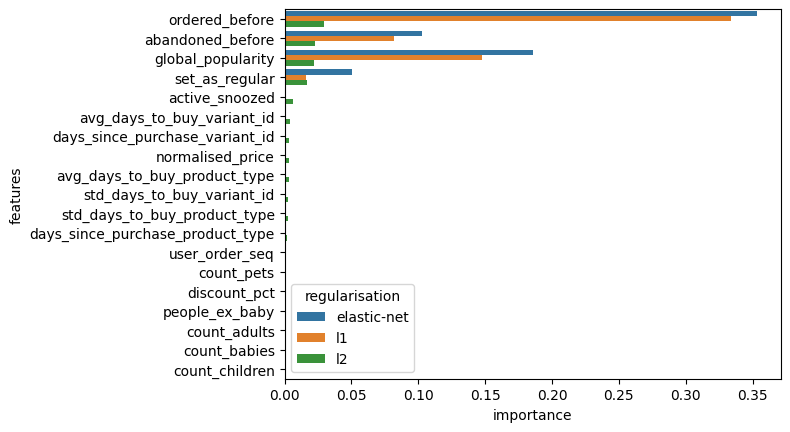

In [67]:
all_coeffs = pd.concat([ridge_coeffs, lasso_coeffs, elnet_coeffs])
all_coeffs["features"] = pd.Categorical(all_coeffs["features"])
all_coeffs = all_coeffs.sort_values("importance", ascending=False)
colum_order = ridge_coeffs.sort_values("importance", ascending=False)["features"]
sns.barplot(
    data=all_coeffs,
    x="importance",
    y="features",
    hue="regularisation",
    order=colum_order
)

As expected, Lasso assigns larger weights to a few variables and sets the rest to 0, while Ridge balances these weights among a larger number of features.

## Feature Selection
Let's retrain using only the top 5 variables.

In [87]:
training_cols = colum_order[:5]
print(training_cols)

0       ordered_before
1     abandoned_before
7    global_popularity
3       set_as_regular
2       active_snoozed
Name: features, dtype: object


### Lasso - L1

In [76]:
lasso_train_results = {}
lasso_test_results = {}
lasso_test_results["baseline"] = baseline['probability']


cs = [1e-8, 1e-6, 1e-4, 1e-2, 1, 100, 1e4]
for c in cs:
    rl = make_pipeline(
        StandardScaler(),
        LogisticRegression(
            penalty='l1',
            C=c,
            solver='saga',
            )
    )
    rl.fit(X=X_train[training_cols], y=y_train)

    train_probs = rl.predict_proba(X_train[training_cols])[:, 1]
    lasso_train_results[f"c={c}"] = train_probs

    test_probs = rl.predict_proba(X_test[training_cols])[:, 1]
    lasso_test_results[f"c={c}"] = test_probs

(<Figure size 1500x600 with 2 Axes>,
 (<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
  <Axes: title={'center': 'Precision-Recall Curves'}, xlabel='Recall', ylabel='Precision'>))

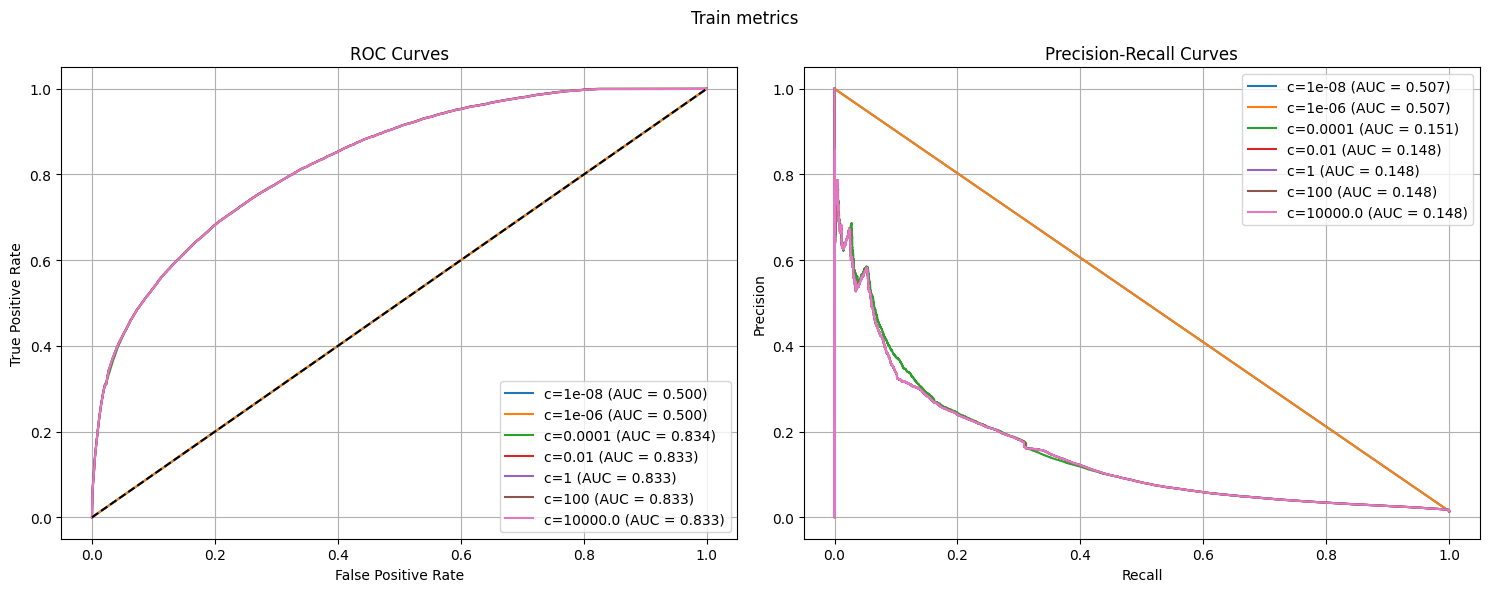

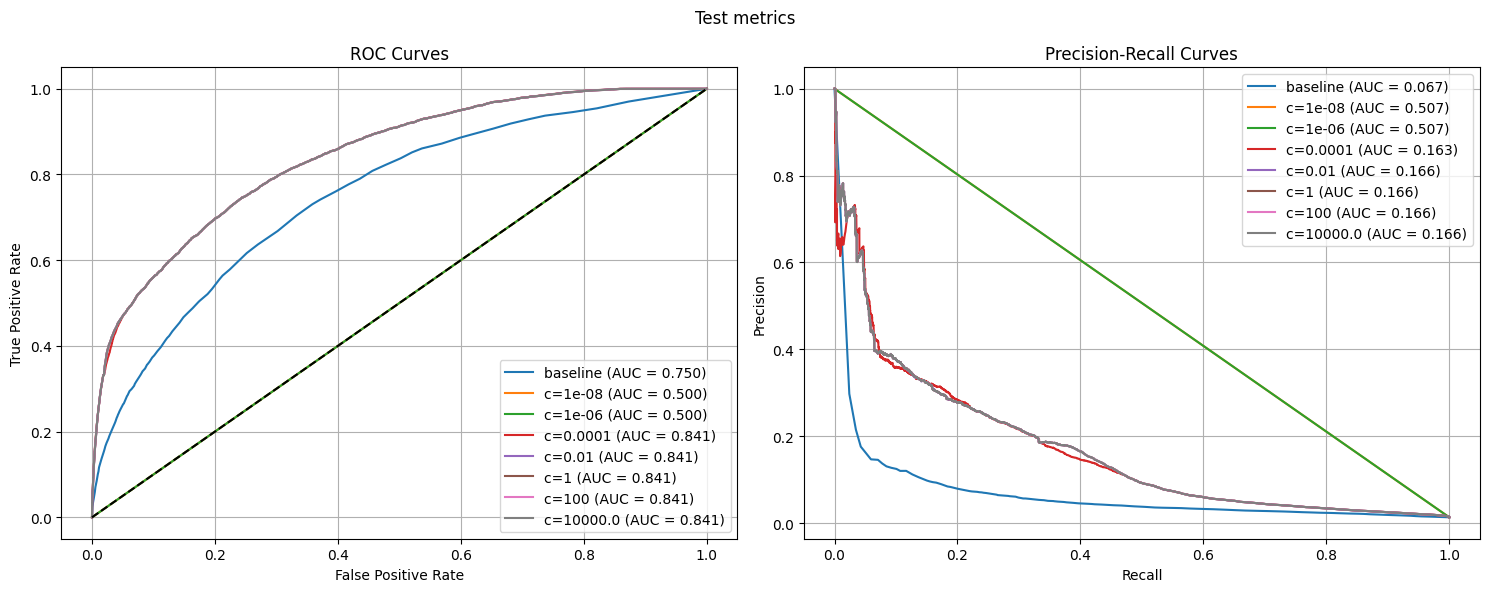

In [77]:
plot_evaluation_metrics(
    y_train,
    lasso_train_results,
    title="Train metrics",
    )


plot_evaluation_metrics(
    y_test,
    lasso_test_results, 
    title="Test metrics",
    )

### Ridge - L2

In [78]:
ridge_train_results = {}
ridge_test_results = {}
ridge_test_results["baseline"] = baseline['probability']


cs = [1e-8, 1e-6, 1e-4, 1e-2, 1, 100, 1e4]
for c in cs:
    rl = make_pipeline(
        StandardScaler(),
        LogisticRegression(
            penalty='l2',
            C=c,
            solver='saga',
        )
    )
    rl.fit(X=X_train[training_cols], y=y_train)

    train_probs = rl.predict_proba(X_train[training_cols])[:, 1]
    ridge_train_results[f"c={c}"] = train_probs

    test_probs = rl.predict_proba(X_test[training_cols])[:, 1]
    ridge_test_results[f"c={c}"] = test_probs

(<Figure size 1500x600 with 2 Axes>,
 (<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
  <Axes: title={'center': 'Precision-Recall Curves'}, xlabel='Recall', ylabel='Precision'>))

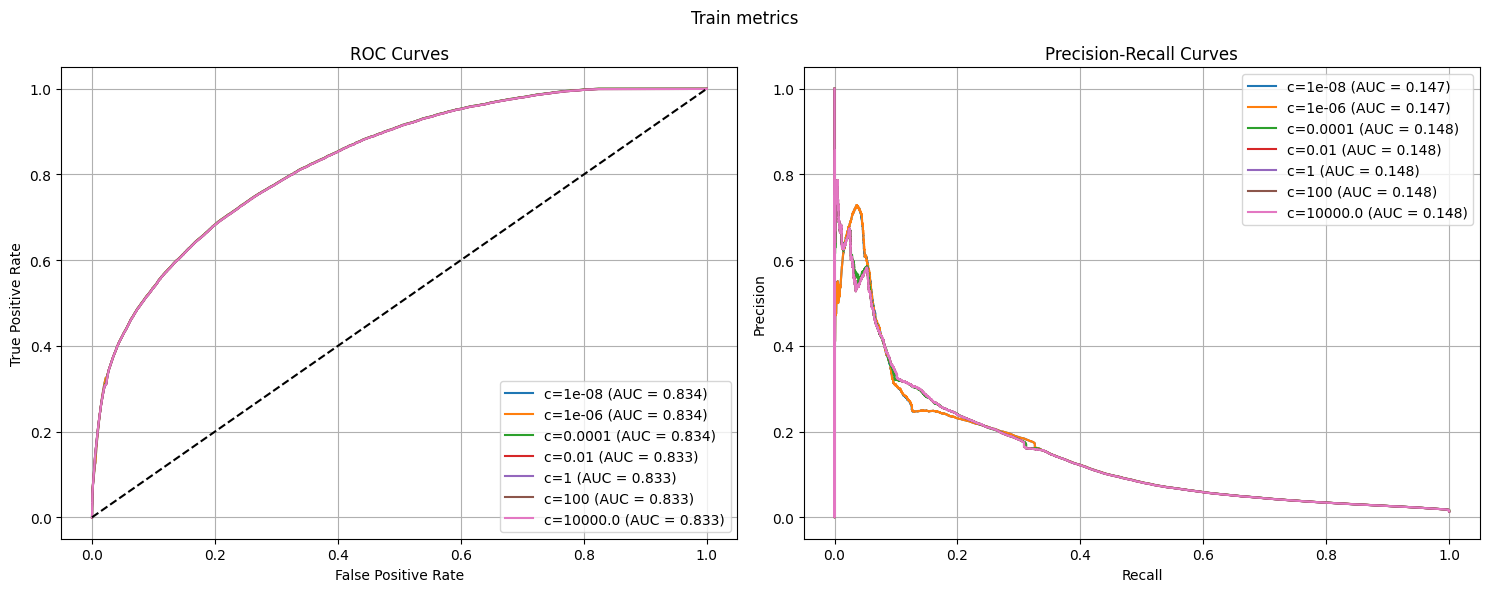

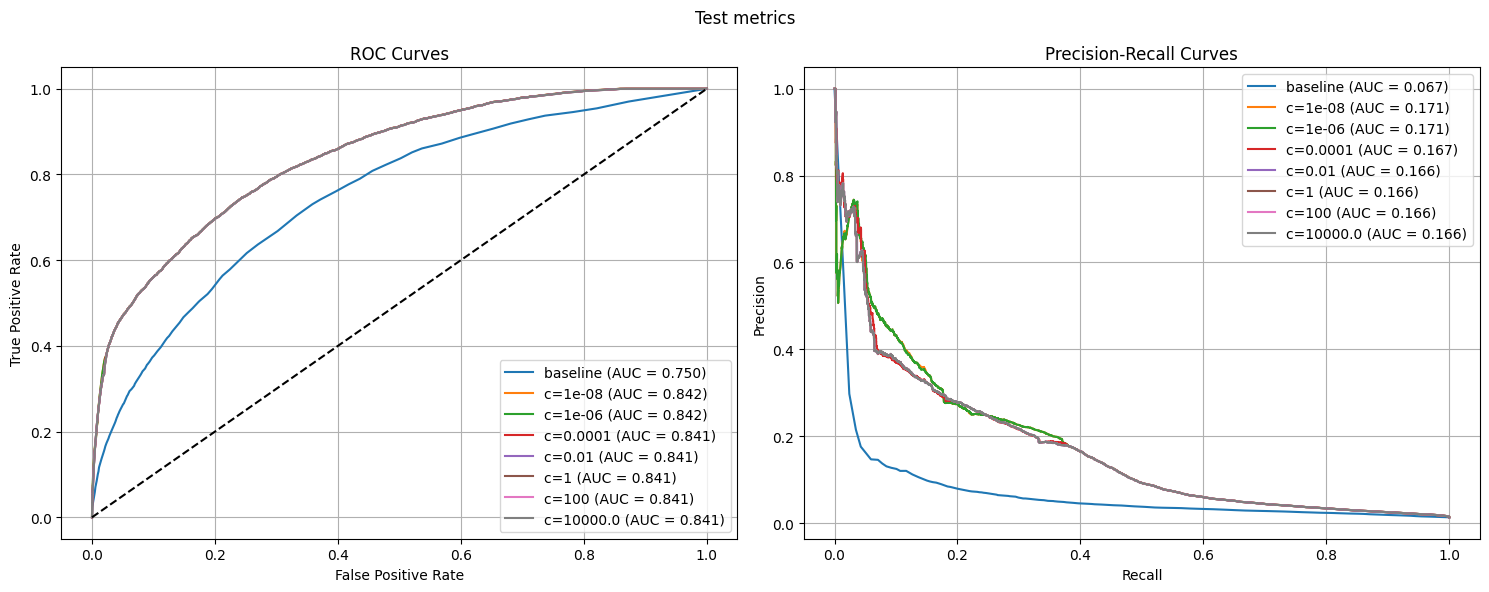

In [79]:
plot_evaluation_metrics(
    y_train,
    ridge_train_results,
    title="Train metrics",
    )


plot_evaluation_metrics(
    y_test,
    ridge_test_results, 
    title="Test metrics",
    )

### Elastic-Net

In [80]:
elnet_train_results = {}
elnet_test_results = {}
elnet_test_results["baseline"] = baseline['probability']


l1_rates = np.arange(0.1, 1.0, 0.1).round(1).tolist()
c = 1e-4 # El mejor hasta ahora
for l1_ratio in l1_rates:
    rl = make_pipeline(
        StandardScaler(),
        LogisticRegression(
            penalty='elasticnet',
            l1_ratio=l1_ratio,
            C=c,
            solver='saga',
            )
    )
    rl.fit(X=X_train[training_cols], y=y_train)

    train_probs = rl.predict_proba(X_train[training_cols])[:, 1]
    elnet_train_results[f"l1={l1_ratio}"] = train_probs

    test_probs = rl.predict_proba(X_test[training_cols])[:, 1]
    elnet_test_results[f"l1={l1_ratio}"] = test_probs

(<Figure size 1500x600 with 2 Axes>,
 (<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
  <Axes: title={'center': 'Precision-Recall Curves'}, xlabel='Recall', ylabel='Precision'>))

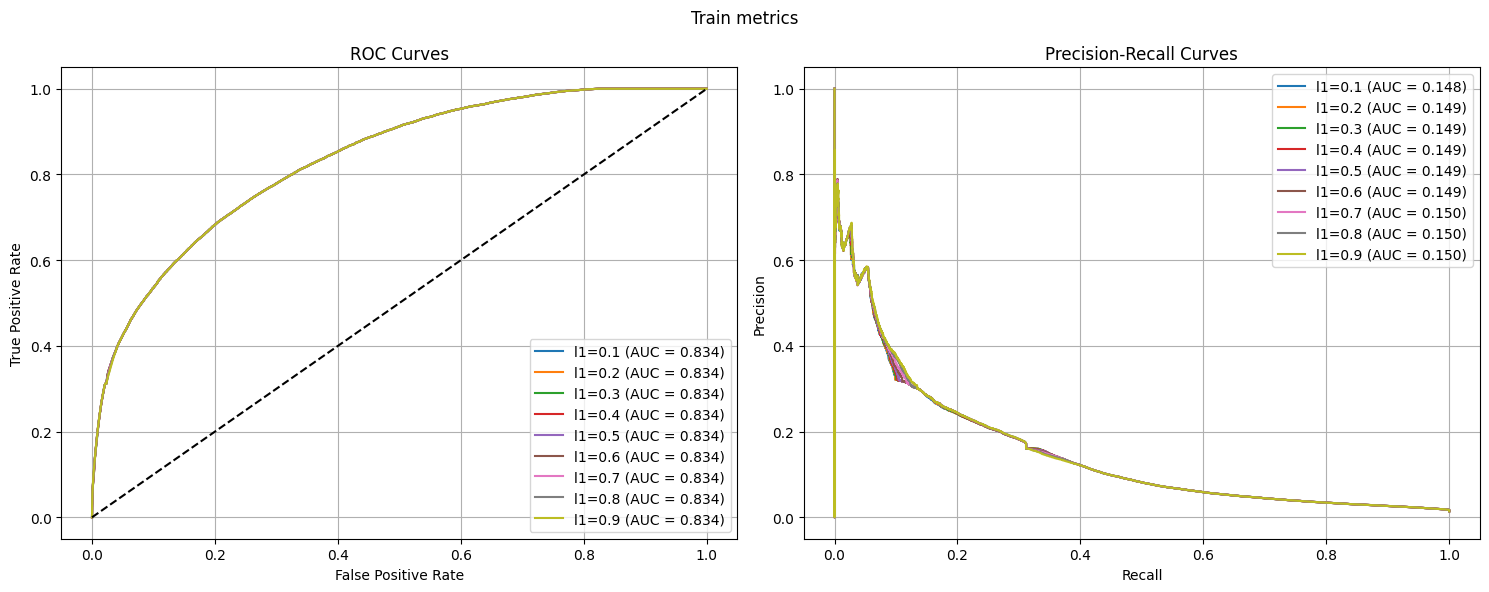

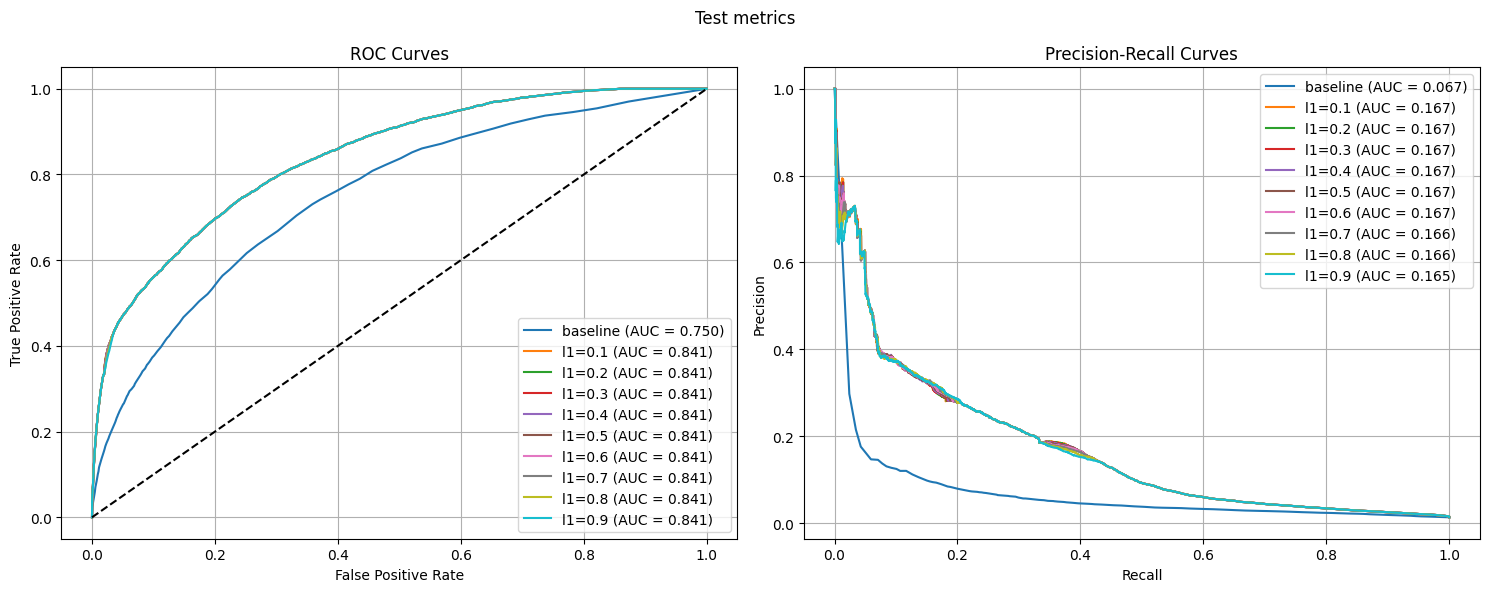

In [81]:
plot_evaluation_metrics(
    y_train,
    elnet_train_results,
    title="Train metrics",
    )

plot_evaluation_metrics(
    y_test,
    elnet_test_results, 
    title="Test metrics",
    )

### Conclusion
We obtain the same results, which indicates that these 5 features capture most of the predictive power, and we always want to keep the model as simple as possible, therefore we would choose one of these as the main model.

In [88]:
lr = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty='l1', C=1e-4, solver="saga")
)
lr.fit(X_train[training_cols], y_train)
lasso_coeffs = pd.DataFrame(
    {
        "features": training_cols,
        "importance": np.abs(lr.named_steps["logisticregression"].coef_[0]),
        "regularisation": ["l1"] * len(training_cols)
    }
)
lasso_coeffs = lasso_coeffs.sort_values("importance", ascending=False)


lr = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty='l2', C=1e-6, solver="saga")
)
lr.fit(X_train[training_cols], y_train)
ridge_coeffs = pd.DataFrame(
    {
        "features": training_cols,
        "importance": np.abs(lr.named_steps["logisticregression"].coef_[0]),
        "regularisation": ["l2"] * len(training_cols)
    }
)
ridge_coeffs = ridge_coeffs.sort_values("importance", ascending=False)


lr = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty='elasticnet', C=1e-4, l1_ratio=0.4, solver="saga")
)
lr.fit(X_train[training_cols], y_train)
elnet_coeffs = pd.DataFrame(
    {
        "features": training_cols,
        "importance": np.abs(lr.named_steps["logisticregression"].coef_[0]),
        "regularisation": ["elastic-net"] * len(training_cols)
    }
)
elnet_coeffs = elnet_coeffs.sort_values("importance", ascending=False)

<Axes: xlabel='importance', ylabel='features'>

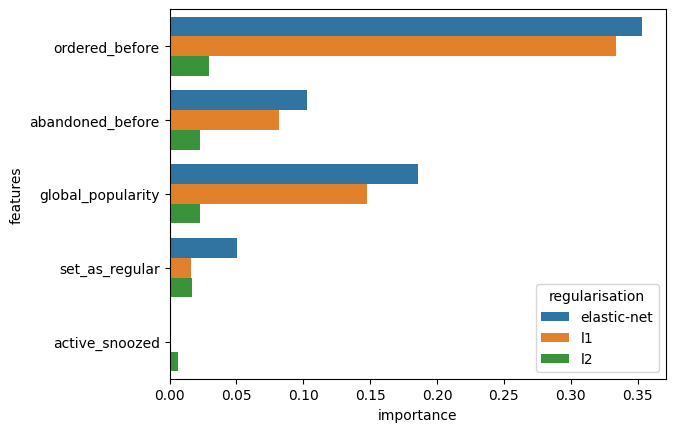

In [89]:
all_coeffs = pd.concat([ridge_coeffs, lasso_coeffs, elnet_coeffs])
all_coeffs["features"] = pd.Categorical(all_coeffs["features"])
all_coeffs = all_coeffs.sort_values("importance", ascending=False)
colum_order = ridge_coeffs.sort_values("importance", ascending=False)["features"]
sns.barplot(
    data=all_coeffs,
    x="importance",
    y="features",
    hue="regularisation",
    order=colum_order
)

There are no changes in the weights that the models assign so the models' behavior is consistent and seems that the models decisions are based on stable relationships between these features and the target variable.

## Training with Categorical Features

In [95]:
new_training_cols = pd.concat([training_cols, pd.Series(categorical_cols)])
print(new_training_cols)

0       ordered_before
1     abandoned_before
7    global_popularity
3       set_as_regular
2       active_snoozed
0         product_type
1               vendor
dtype: object


In [114]:
print("Complete Dataset:")
for col in categorical_cols:
    print("-----------------------------------------------------")
    print(f"Column: {col} | Unique Values: {df_filtered[col].nunique()}")
    print(f"Column: {col} | Most Frequent Value: {df_filtered[col].mode()[0]} | Count: {df_filtered[col].value_counts().max()} | Percentage: {df_filtered[col].value_counts(normalize=True).max() * 100:.2f}%")
    print(f"Column: {col} | Least Frequent Value: {df_filtered[col].value_counts().idxmin()} | Count: {df_filtered[col].value_counts().min()} | Percentage: {df_filtered[col].value_counts(normalize=True).min() * 100:.2f}%")

print("\n\nTrain Data:")
for col in categorical_cols:
    print("-----------------------------------------------------")
    print(f"Column: {col} | Unique Values: {train_df[col].nunique()}")

print("\n\nTest Data:")
for col in categorical_cols:
    print("-----------------------------------------------------")
    print(f"Column: {col} | Unique Values: {test_df[col].nunique()}")

Complete Dataset:
-----------------------------------------------------
Column: product_type | Unique Values: 62
Column: product_type | Most Frequent Value: tinspackagedfoods | Count: 144931 | Percentage: 8.06%
Column: product_type | Least Frequent Value: premixedcocktails | Count: 1841 | Percentage: 0.10%
-----------------------------------------------------
Column: vendor | Unique Values: 264
Column: vendor | Most Frequent Value: biona | Count: 89569 | Percentage: 4.98%
Column: vendor | Least Frequent Value: vicks | Count: 171 | Percentage: 0.01%


Train Data:
-----------------------------------------------------
Column: product_type | Unique Values: 62
-----------------------------------------------------
Column: vendor | Unique Values: 250


Test Data:
-----------------------------------------------------
Column: product_type | Unique Values: 62
-----------------------------------------------------
Column: vendor | Unique Values: 264


Here I think there are two very important things to consider:
- 1. Both 'features' have high cardinality and don't have an ordinal relationship between their values. Therefore, the encoding strategy that I think would be appropriate to implement in this case would be **Frequency Encoding**.
- 2. It's important to highlight that in the test data there are more unique values in the `vendor` column than in the training dataset. This appears to be a typical problem in machine learning that can perfectly occur in any real project. From what I've been able to research, it's known as **"unseen categories"**.
Since this is the first time I've encountered this problem, the way I think to approach it would be to preprocess the test dataset before making predictions and assign either `0` or the smallest frequency present in the training dataset to variables not seen by the model during training.

Nota final:

Debido a la falta de tiempo y al alto ritmo al que avanza el programa prefiero comentar mi razonamiento y posible solución y no seguir aquí con el desarrollo del código. En el siguiente proyecto del módulo 4 con modelos no lineales trataré de implementarlo.

In [1]:
!jupyter nbconvert --to markdown "linear_models.ipynb"

[NbConvertApp] Converting notebook linear_models.ipynb to markdown
[NbConvertApp] Support files will be in linear_models_files/
[NbConvertApp] Making directory linear_models_files
[NbConvertApp] Writing 50887 bytes to linear_models.md
